In [1168]:
import random
import numpy as np
from deap import base, creator, tools, algorithms
import networkx as nx
import matplotlib.pyplot as plt
import copy

In [1169]:
stations = ['A', 'B', 'C', 'D', 'E', 'S1', 'S2']
transitions = {
    'S1': ['A', 'B', 'C'],
    'S2': ['A', 'B', 'C', 'D', 'E']
}

In [1170]:
mul_list = [
    {
        'st': 'A'
    },
    {
        'st': 'B'
    },
    {
        'st': 'B'
    },
]

In [1171]:
lacomotive_type = ['S1', 'S2']

vagon_list = [
    {
        'st': 'A',  # станция на которой он находится на данный момент
    },
    {
        'st': 'A',
    },
    {
        'st': 'A',
    },
    {
        'st': 'A',
    },
    {
        'st': 'A',
    },
    {
        'st': 'A',
    },
    {
        'st': 'B',
    },
    {
        'st': 'B',
    },
    {
        'st': 'B',
    },
    {
        'st': 'C',
    },
    {
        'st': 'C',
    },
    {
        'st': 'C',
    },
    {
        'st': 'D',
    },
    {
        'st': 'D',
    },
    {
        'st': 'E',
    },
    {
        'st': 'E',
    },
    {
        'st': 'E',
    },
]

for vagon in vagon_list:
    vagon['was_in_train'] = -1  # флажок на каком шаге он попал в поезд. Если -1, то не попал
    vagon['history'] = [None] * 10  # история всех событий. По сути это расписание, которое мы отправим на фронт. Если None - то в этот момент был простой, если str - название станции, куда передвинули

In [1172]:
G = nx.Graph()
color_map = []
color_nodes = ['orange' for _ in range(len(stations))] + ['green' for _ in range(len(vagon_list))]

for key, value in transitions.items():
    for val in value:
        G.add_edge(key, val, color='b', weight=3)
        color_map.append('orange')

for i in range(len(vagon_list)):
    G.add_edge(vagon_list[i]['st'], f"ID: {i}", color='g', weight=1, capacity=15)
    color_map.append('blue')

{'S1': Text(-0.39463489500456517, -0.05310106911566992, 'S1'),
 'A': Text(-0.28338410104160394, 0.6816885724535457, 'A'),
 'B': Text(-0.7764882751759181, -0.3306332337201945, 'B'),
 'C': Text(-0.037878524573182, -0.7529931853805854, 'C'),
 'S2': Text(0.07626834688084479, -0.04545450737489096, 'S2'),
 'D': Text(0.7235869360639728, -0.4806321182723049, 'D'),
 'E': Text(0.7910583998899292, 0.3601786972293804, 'E'),
 'ID: 0': Text(-0.07743121263156837, 0.7686934182241201, 'ID: 0'),
 'ID: 1': Text(-0.22052876013076272, 0.8991074331331218, 'ID: 1'),
 'ID: 2': Text(-0.41888933366274567, 0.8614103276950487, 'ID: 2'),
 'ID: 3': Text(-0.5122445620261447, 0.6907769265519458, 'ID: 3'),
 'ID: 4': Text(-0.40295422266833286, 0.5211482311147004, 'ID: 4'),
 'ID: 5': Text(-0.13120500982878872, 0.5601717434608894, 'ID: 5'),
 'ID: 6': Text(-0.9255060381670873, -0.1755188853257004, 'ID: 6'),
 'ID: 7': Text(-0.9831687070753077, -0.4236987317114074, 'ID: 7'),
 'ID: 8': Text(-0.7543531099128689, -0.5404082061

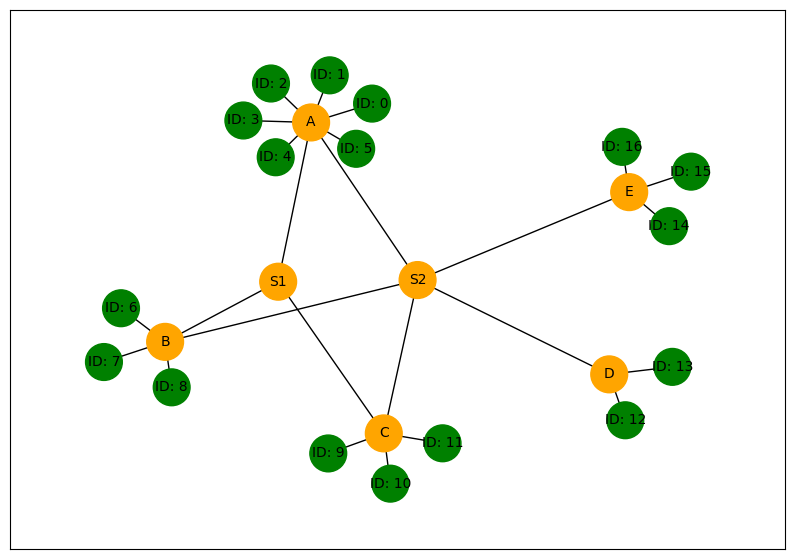

In [1173]:
plt.figure(figsize =(10, 7))

pos = nx.kamada_kawai_layout(G,)
nx.draw_networkx_nodes(G, pos, node_size=700, margins=0.1, node_color=color_nodes)
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_labels(G, pos, font_size=10, font_family="sans-serif")

In [1174]:
MUL_COUNT = len(mul_list)
OPERATIONS_FOR_MUL = [
    'move_to',
    'cheel'
]
MAX_MUL_OPERATIONS = 10
LENGTH_CHROM = MUL_COUNT * MAX_MUL_OPERATIONS     # длина хромосомы, подлежащей оптимизации
TRAIN_LIVE_TIME = {
    'S1': 5,
    'S2': 6
}

VAGON_OPERATIONS = {
    'idle': 2,
    'move': 8
}

# константы генетического алгоритма
POPULATION_SIZE = 400   # количество индивидуумов в популяции
P_CROSSOVER = 0.9       # вероятность скрещивания
P_MUTATION = 0.2        # вероятность мутации индивидуума
MAX_GENERATIONS = 5000    # максимальное количество поколений
HALL_OF_FAME_SIZE = 2

In [1175]:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

In [1176]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

In [1177]:
def create_individ(max_range, count):
    operations_count = random.randint(1, count)
    res = {
        'commands': []
    }
    for _ in range(count):
        if operations_count > 0:
            new_oper = random.randint(0, max_range)
            if new_oper == 0:
                station = random.choice(stations)
                res['commands'].append({f'{new_oper}': {"to": station, "who": random.randint(0, len(vagon_list)-1)}})
            else:
                res['commands'].append({f'{new_oper}': None})
        else:
            res['commands'].append({'1': None})
        operations_count -= 1
    return res

In [1178]:
create_individ(len(OPERATIONS_FOR_MUL) - 1, MAX_MUL_OPERATIONS)

{'commands': [{'0': {'to': 'S1', 'who': 8}},
  {'0': {'to': 'B', 'who': 4}},
  {'1': None},
  {'1': None},
  {'1': None},
  {'1': None},
  {'1': None},
  {'1': None},
  {'1': None},
  {'1': None}]}

In [1179]:
toolbox = base.Toolbox()
toolbox.register("randomOper", create_individ, len(OPERATIONS_FOR_MUL) - 1, MAX_MUL_OPERATIONS)
toolbox.register("individualCreator", tools.initRepeat, creator.Individual, toolbox.randomOper, MUL_COUNT)
toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator)

In [1180]:
population = toolbox.populationCreator(n=MUL_COUNT)
population

[[{'commands': [{'0': {'to': 'E', 'who': 13}},
    {'0': {'to': 'A', 'who': 2}},
    {'1': None},
    {'1': None},
    {'1': None},
    {'1': None},
    {'1': None},
    {'1': None},
    {'1': None},
    {'1': None}]},
  {'commands': [{'0': {'to': 'E', 'who': 0}},
    {'0': {'to': 'S1', 'who': 13}},
    {'0': {'to': 'D', 'who': 8}},
    {'0': {'to': 'S2', 'who': 5}},
    {'1': None},
    {'1': None},
    {'1': None},
    {'1': None},
    {'1': None},
    {'1': None}]},
  {'commands': [{'1': None},
    {'1': None},
    {'0': {'to': 'B', 'who': 10}},
    {'0': {'to': 'A', 'who': 12}},
    {'0': {'to': 'C', 'who': 11}},
    {'1': None},
    {'0': {'to': 'S1', 'who': 14}},
    {'1': None},
    {'1': None},
    {'1': None}]}],
 [{'commands': [{'0': {'to': 'D', 'who': 2}},
    {'1': None},
    {'1': None},
    {'0': {'to': 'S1', 'who': 2}},
    {'0': {'to': 'S1', 'who': 7}},
    {'1': None},
    {'0': {'to': 'S2', 'who': 7}},
    {'0': {'to': 'D', 'who': 8}},
    {'1': None},
    {'1': None}

In [1181]:
def is_conflict(command_list: list) -> bool:
    "Проверка: тащат ли несколько мулов один вагон?"
    vagon_move = []
    for command in command_list:  # command = {'1': None} / {'0': {'to': 'B', 'who': 3}}
        key, val = list(command.items())[0]
        if key == '0':
            if val['who'] in vagon_move: return True
            vagon_move.append(val['who'])
    return False 

def new_vagon_state(new_vagon_list, command_list, time):
    "обновление расписания вагонов. Только обновление на основании расчетов мулов"
    new_state_for_vagon = {}  # список изменений, которые произшли за единицу времени


    # составляем что-то вроде общего расписания за единицу времени
    for command in command_list:
        key, val = list(command.items())[0]
        if key == '0':
            vagon = new_vagon_list[val['who']]
            vagon['st'] = val['to']
            if val['to'] in ['S1', 'S2']:  # если мы попали в поезд
                vagon['was_in_train'] = time  # устанавливаем временную отметку
            new_state_for_vagon[f'{val["who"]}'] = val['to']
    
    for key, val in new_state_for_vagon.items():
        new_vagon_list[int(key)]['history'][time] = val  # если вагон двигали, то записываем это в историю вагонов

    return new_vagon_list

In [1182]:
PENALTY_COST = 20

def shedule_cost(individual):
    "Эту функцию я всю проверил в ручную, работает правильно"
    current_cost = 0
    penalty_count = 0

    new_vagon_list = copy.deepcopy(vagon_list)  # это глубокое копирование, чтобы скопировались все элементы вснутри списка

    # синхронизируем действия мулов

    for time in range(MAX_MUL_OPERATIONS):
        command_list = [individual[mul]['commands'][time] for mul in range(MUL_COUNT)]
        if is_conflict(command_list):
            penalty_count += 1
        
        new_vagon_state(new_vagon_list, command_list, time)  # состовляем расписание

    # проведем стоимость расписания

    for i, vagon in enumerate(new_vagon_list):
        train = None
        for time in range(len(vagon['history'])):
            command = vagon['history'][time]
            if train is not None and time >= TRAIN_LIVE_TIME[train] and vagon['was_in_train'] <= TRAIN_LIVE_TIME[train]:  # если мы в поезде и поезд уже уехал
                if command is not None:  # если после отъезда поезда мы решили перекинуть вагон, то...
                    penalty_count += 1  # бан
            else:
                if command is None:
                    current_cost += VAGON_OPERATIONS['idle']
                else:
                    if command in ['S1', 'S2']:
                        train = command
                        penalty_count += 1 if time > TRAIN_LIVE_TIME[train] else 0  # если мы попали в поезд после его отправления, то бан
                    else:
                        train = None
                    current_cost += VAGON_OPERATIONS['move']

    current_cost += penalty_count * PENALTY_COST  # прибавляем штраф к общей сумме
    return current_cost,

In [1183]:
population[0]

[{'commands': [{'0': {'to': 'E', 'who': 13}},
   {'0': {'to': 'A', 'who': 2}},
   {'1': None},
   {'1': None},
   {'1': None},
   {'1': None},
   {'1': None},
   {'1': None},
   {'1': None},
   {'1': None}]},
 {'commands': [{'0': {'to': 'E', 'who': 0}},
   {'0': {'to': 'S1', 'who': 13}},
   {'0': {'to': 'D', 'who': 8}},
   {'0': {'to': 'S2', 'who': 5}},
   {'1': None},
   {'1': None},
   {'1': None},
   {'1': None},
   {'1': None},
   {'1': None}]},
 {'commands': [{'1': None},
   {'1': None},
   {'0': {'to': 'B', 'who': 10}},
   {'0': {'to': 'A', 'who': 12}},
   {'0': {'to': 'C', 'who': 11}},
   {'1': None},
   {'0': {'to': 'S1', 'who': 14}},
   {'1': None},
   {'1': None},
   {'1': None}]}]

In [1184]:
shedule_cost(population[0])

(402,)

In [1185]:
def mate(ind1, ind2):
    for i in range(len(ind1)):
        ind1[i]['commands'], ind2[i]['commands'] = tools.cxTwoPoint(ind1[i]['commands'], ind2[i]['commands'])
    return ind1, ind2

In [1186]:
def mut(individual, indpb):
    for i in range(len(individual)):
        if individual[i]['commands'].count(individual[i]['commands'][0]) == len(individual[i]['commands']):  # если мул состоит из одни и тех же команд (например одни простои), то заполняем радомом новые значения
            rand_ind = random.randint(4, len(individual[i]['commands']) // 2)
            index_to_mut = random.sample(range(len(individual[i]['commands'])), rand_ind)
            for j in index_to_mut:
                station = random.choice(stations)
                individual[i]['commands'][j] = {'0': {"to": station, "who": random.randint(0, len(vagon_list)-1)}}
                
        individual[i]['commands'] = list(tools.mutShuffleIndexes(individual[i]['commands'], indpb))[0]
    return individual,

In [1187]:
toolbox.register("evaluate", shedule_cost)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", mate)
toolbox.register("mutate", mut, indpb=1.0/MAX_MUL_OPERATIONS/5)

In [1188]:
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("min", np.min)
stats.register("avg", np.mean)

In [1189]:
hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

In [1190]:
population, logbook = algorithms.eaSimple(population, toolbox,
                                        cxpb=P_CROSSOVER/MUL_COUNT,
                                        mutpb=P_MUTATION/MUL_COUNT,
                                        ngen=MAX_GENERATIONS,
                                        halloffame=hof,
                                        stats=stats,
                                        verbose=True)

gen	nevals	min	avg    
0  	3     	396	409.333
1  	0     	396	398    
2  	0     	396	396    
3  	0     	396	396    
4  	1     	396	396    
5  	0     	396	396    
6  	2     	396	396    
7  	2     	396	396    
8  	0     	396	396    
9  	0     	396	396    
10 	0     	396	396    
11 	0     	396	396    
12 	0     	396	396    
13 	1     	396	396    
14 	0     	396	396    
15 	2     	396	396    
16 	2     	396	396    
17 	0     	396	396    
18 	0     	396	396    
19 	1     	396	396    
20 	0     	396	396    
21 	0     	396	396    
22 	0     	396	396    
23 	2     	396	396    
24 	2     	396	396    
25 	0     	396	396    
26 	0     	396	396    
27 	1     	396	396    
28 	0     	396	396    
29 	0     	396	396    
30 	0     	396	396    
31 	0     	396	396    
32 	0     	396	396    
33 	2     	396	396    
34 	2     	396	396    
35 	1     	396	396    
36 	0     	396	396    
37 	1     	396	396    
38 	0     	396	396    
39 	0     	396	396    
40 	0     	396	396    
41 	0     	396	396    
42 	2     	

108	1     	396	396    
109	2     	396	396    
110	1     	396	396    
111	0     	396	396    
112	2     	396	396    
113	2     	396	396    
114	2     	396	396    
115	0     	396	396    
116	0     	396	396    
117	1     	396	396    
118	2     	396	396    
119	1     	396	396    
120	0     	396	396    
121	2     	396	396    
122	2     	396	396    
123	2     	396	396    
124	2     	396	396    
125	0     	396	396    
126	0     	396	396    
127	0     	396	396    
128	0     	396	396    
129	0     	396	396    
130	0     	396	396    
131	0     	396	396    
132	2     	396	396    
133	0     	396	396    
134	0     	396	396    
135	0     	396	396    
136	0     	396	396    
137	0     	396	396    
138	0     	396	396    
139	0     	396	396    
140	0     	396	396    
141	0     	396	396    
142	0     	396	396    
143	0     	396	396    
144	2     	396	396    
145	1     	396	396    
146	2     	396	396    
147	2     	396	396    
148	0     	396	396    
149	2     	396	396    
150	0     	396	396    
151	0     	

In [1191]:
maxFitnessValues, meanFitnessValues = logbook.select("min", "avg")

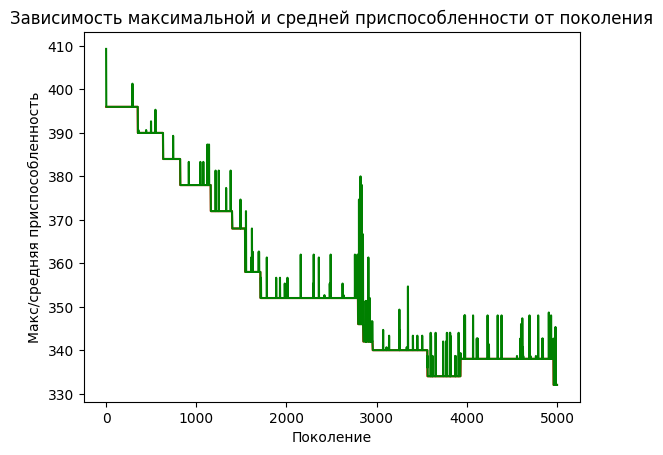

In [1192]:
plt.plot(maxFitnessValues, color='red')
plt.plot(meanFitnessValues, color='green')
plt.xlabel('Поколение')
plt.ylabel('Макс/средняя приспособленность')
plt.title('Зависимость максимальной и средней приспособленности от поколения')
 
plt.show()

In [1193]:
best_shedule = hof.items[0]
best_shedule

[{'commands': [{'1': None},
   {'0': {'to': 'S1', 'who': 14}},
   {'1': None},
   {'1': None},
   {'0': {'to': 'S1', 'who': 0}},
   {'1': None},
   {'1': None},
   {'1': None},
   {'1': None},
   {'1': None}]},
 {'commands': [{'1': None},
   {'1': None},
   {'1': None},
   {'0': {'to': 'S2', 'who': 1}},
   {'1': None},
   {'1': None},
   {'1': None},
   {'1': None},
   {'1': None},
   {'1': None}]},
 {'commands': [{'1': None},
   {'0': {'to': 'E', 'who': 3}},
   {'0': {'to': 'S1', 'who': 3}},
   {'1': None},
   {'1': None},
   {'1': None},
   {'1': None},
   {'1': None},
   {'1': None},
   {'1': None}]}]